# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "ALL_10-800_LOOSE" #"CAINGSGII_10-800" #"TDS" #"CAINGSGII_10-800" #"WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_cat_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler,add_ogrp, color_palette, nb_fig

# Get region
rc = Region()
rc.load_from_fits(region_cat_fname)

### Prepare association data for plotting

In [3]:
#Add Object group to source table
rc.copy_table_columns("tt_sources","tt_simbad",["otype","ogrp","match_distance"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_simbad")
rc.tt_sources.rename_column("ogrp","ogrp_simbad")
sel_simbad = rc.tt_sources["sel"].data
print(f"Number of SIMBAD matches is: {sel_simbad.sum()}  ({100* sel_simbad.sum() / len(rc.tt_sources)} )%")

rc.copy_table_columns("tt_sources","tt_gaiadr3",["PQSO", "PGal", "PSS","match_distance","Gmag_abs","BP-RP", "ogrp"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_gaiadr3")
rc.tt_sources.rename_column("ogrp","ogrp_gaiadr3")
sel_gaiadr3 = rc.tt_sources["sel"].data
print(f"Number of GAIA matches is: {sel_gaiadr3.sum()}  ({100*sel_gaiadr3.sum() / len(rc.tt_sources)} )%")

sel_match = np.array(sel_simbad+sel_gaiadr3, dtype=bool)
print(f"Total number of matches is: {sel_match.sum()}  ({100*sel_match.sum() / len(rc.tt_sources)} )%")

#Copy lomb scargle result into tt_sources
rc.copy_table_columns("tt_sources","tt_lombscargle",["ls_peak_pval", "ls_model_rchiq"],"rg_src_id")

display(rc.tt_sources)
#display(rc.tt_simbad)


Number of SIMBAD matches is: 5508  (52.89541918755402 )%
Number of GAIA matches is: 7952  (76.36608086046289 )%
Total number of matches is: 8696  (83.51099587054644 )%


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,simbad_match_id,gaiadr3_match_id,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3,ls_peak_pval,ls_model_rchiq
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,arcsec,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32,float32,int64,int32,int32,float32,float32,int32,int32,bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32
-1,248 .. 144,150.19491669966794,2.0679206386322235,0.034894396,-0.33851302,0.18164578,1.0,0.3224277,959299,0.16131246,1 .. 2,True,14.191161 .. 8.757307,0.06079538 .. 0.09396652,0.0106525235 .. 0.005538589,3.7525566 .. 2.5326197,0.0 .. 1.772165e-13,3.841772 .. 2.1152527,-100.0,-10000.0,-1,227,10,0.6072997,0.0076302565,0,0,Sy1,AGN,0.6982278,0.001869,0.000724,0.996765,0.6982278,-100.0,0.953236,none,1.6287165e-09,3.0704353
-1,252 .. 147,150.17992517033275,2.110325555655416,0.035408843,-0.24451591,0.30744642,0.99999994,0.566374,75245,0.13007154,1 .. 2,True,17.587757 .. 6.551935,0.06531105 .. 0.0799764,0.002130574 .. -0.0008621514,2.4555638 .. 1.3940743,1.3690256e-15 .. 0.583465,1.8763659 .. 0.9710373,-100.0,-10000.0,-1,243,10,0.3645722,0.0049660443,1,1,QSO,AGN,0.8139196,0.000287,0.00016,0.998952,0.8139196,-100.0,1.062943,none,3.4864567e-19,1.2556543
-1,244 .. 114,150.14575215591634,2.0430760561265466,0.03967842,-0.38290083,0.27473727,1.0,0.43058085,75401,0.11261488,1 .. 2,True,9.884236 .. 3.657634,0.05455299 .. 0.07133999,0.031847723 .. 0.033267822,4.287245 .. 1.2234199,0.0 .. 2.4905885e-06,6.90565 .. 1.7280945,-100.0,-10000.0,-1,285,10,0.36859575,0.008322803,3,2,QSO,AGN,0.59233105,0.001265,1.3e-05,0.997987,0.59233105,-100.0,1.103838,none,4.0559136e-08,5.6518145
-1,216 .. 31,150.12385136844162,2.358249206025685,0.05189303,-0.37029192,0.38448596,1.0,0.518402,75516,0.39484766,1 .. 2,True,4.4475236 .. 1.7711709,0.04511629 .. 0.09256162,0.02649166 .. 0.00075723574,1.0877458 .. 0.29965115,1.6119977e-28 .. 0.3227426,2.4625556 .. 1.099846,-100.0,-10000.0,-1,309,10,0.35776442,0.020704556,4,-1,AGN,AGN,0.66436946,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,none,3.9222284e-10,1.884302
-1,212 .. 146,150.10543057525874,1.9811805844319315,0.030431462,-0.13029067,0.21070814,0.999997,0.6266021,7138,0.20995955,1 .. 2,True,76.62371 .. 57.887726,0.1342218 .. 0.23718311,0.010341072 .. 0.015267677,67.61158 .. 67.69357,0.0 .. 0.0,18.9946 .. 5.04877,-100.0,-10000.0,-1,325,10,0.74573404,0.0037610622,6,3,QSO,AGN,0.8567489,1.0,0.0,0.0,0.8449408,-100.0,0.559883,AGN,1.694602e-11,13.979091
-1,254 .. 121,150.1018543930992,2.105635330222158,0.040247425,-0.21038206,0.539894,0.99994904,0.6663007,7145,0.25821337,1 .. 2,True,9.21146 .. 2.9914613,0.052212078 .. 0.06258585,0.005092149 .. -0.008766063,1.6152397 .. 0.5309438,6.099398e-10 .. 0.88895833,1.6382984 .. 0.8454973,-100.0,-10000.0,-1,332,10,0.3268755,0.0076531875,7,4,QSO,AGN,0.81216687,1.0,0.0,0.0,0.80132544,-100.0,0.379698,AGN,0.023827115,1.5077726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,19 .. -1,5.388530300126071,0.7171320746110323,0.11602028,-0.19314274,0.063167915,0.99822867,0.24798724,-1,-1.0,1 .. 0,False,169.20502 .. -1.0,0.7393881 .. -1.0,0.00092433 .. -100.0,47.018005 .. -1.0,4.0640536e-11 .. -1.0,4.8605256 .. -1.0,-100.0,-10000.0,-1,3250848,1,-1.0,-1.0,5595,7982,QSO,AGN,0.79586196,0.999997,0.0,3e-06,0.79718685,-100.0,0.633642,AGN,-1.0,-1.0


### Create matching table

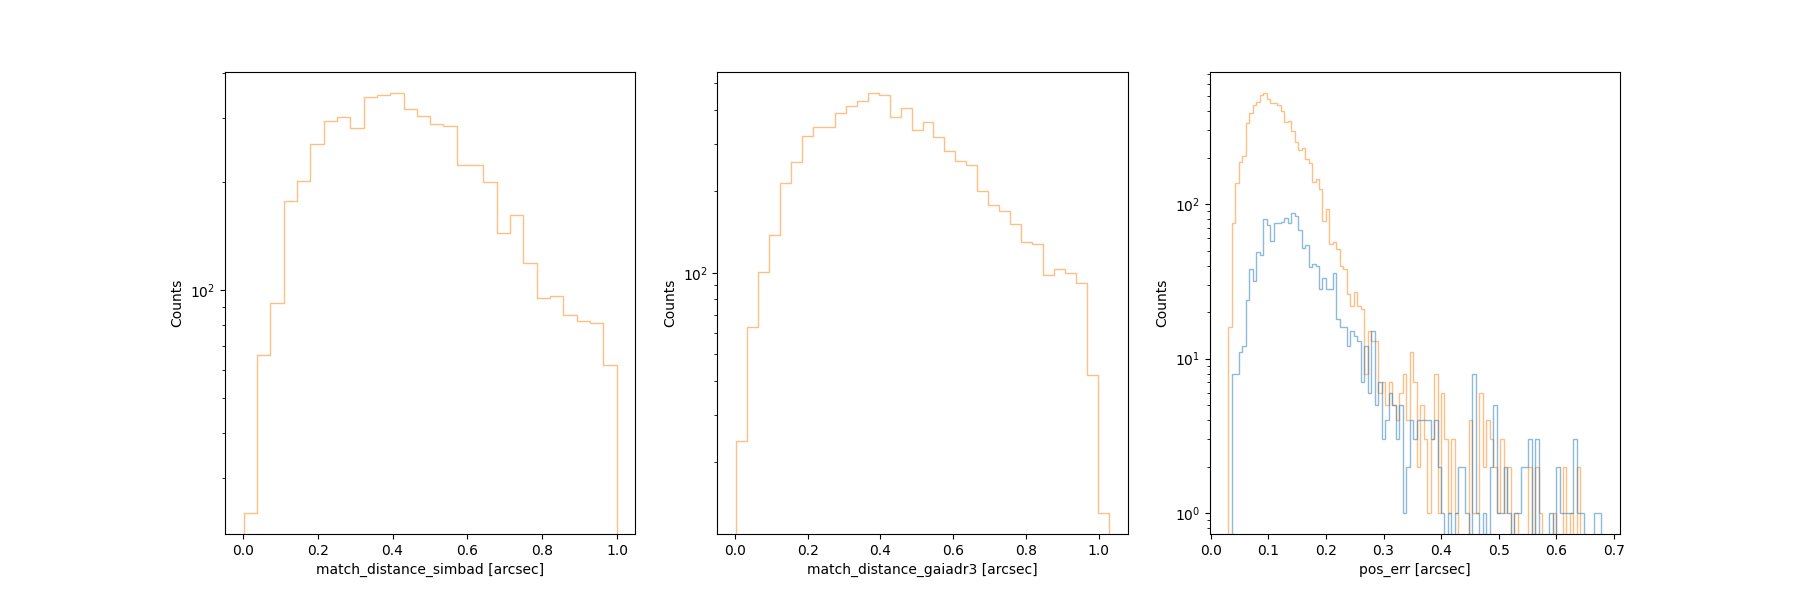

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = np.array(axs).flatten()
rc.tt_sources["sel"]=sel_simbad
_ = vvis.plot_table_hist(rc.tt_sources[sel_simbad], "match_distance_simbad", ax=axs[0], logx=False, obs_filter_id=None, density= False)
rc.tt_sources["sel"]=sel_gaiadr3
_ = vvis.plot_table_hist(rc.tt_sources[sel_gaiadr3], "match_distance_gaiadr3", ax=axs[1], logx=False, obs_filter_id=None, density= False)
rc.tt_sources["sel"]=sel_match
_ = vvis.plot_table_hist(rc.tt_sources, 'pos_err', ax=axs[2], logx=False, obs_filter_id=None, density= False)

### Plot found object types

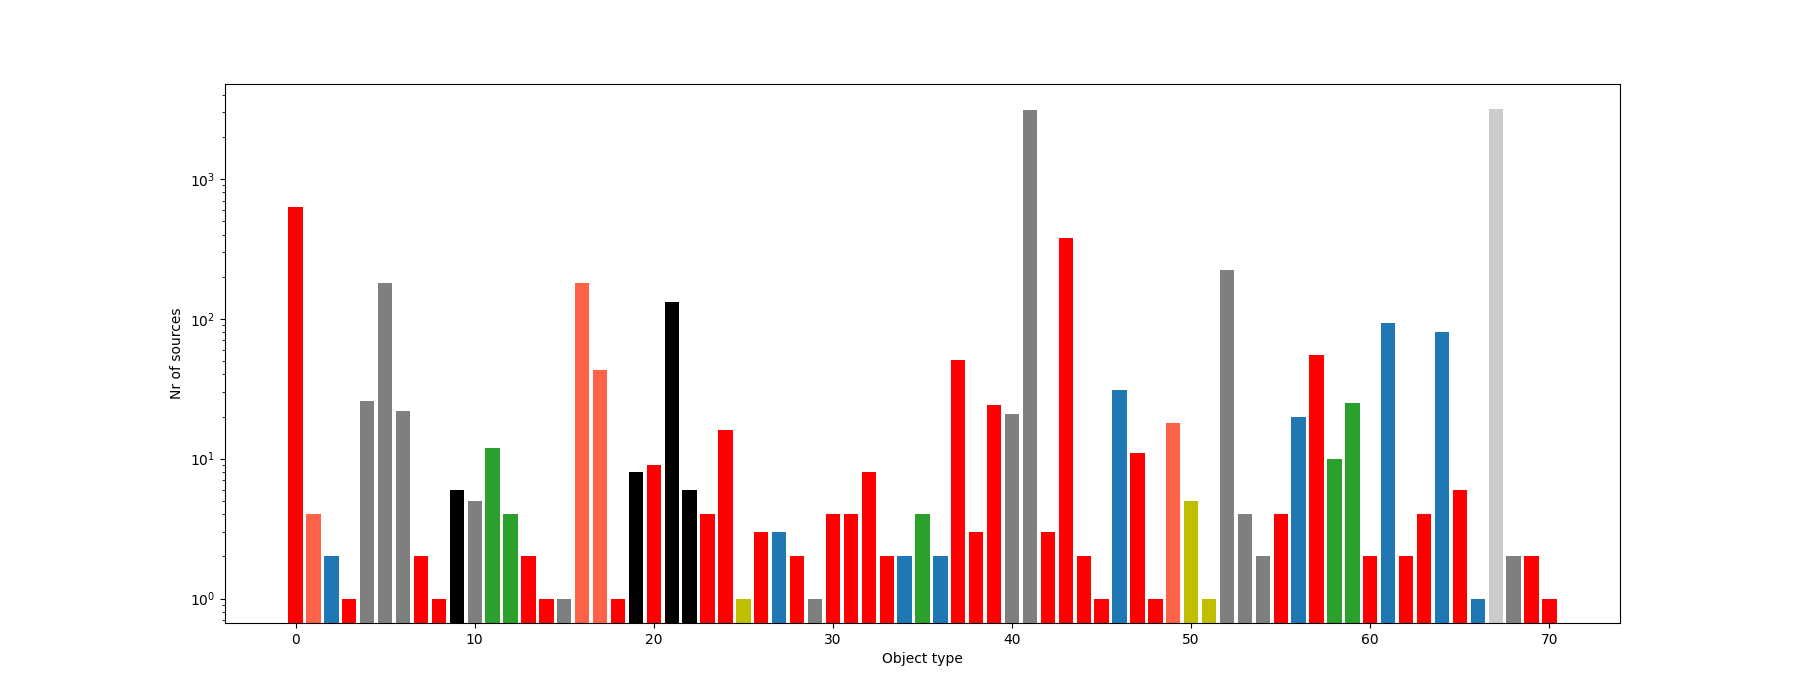

In [5]:
#Prepare data
sel_mt = rc.tt_sources["sel"]
otypes_all, otype_cts_all= np.unique(rc.tt_sources[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

#Do bar chart of all otypes color coded by ogrp
fig_otypes = plt.figure("Source types",figsize=(18, 7), clear=True)
fig_otypes.clf()
tt_mt_grp =  rc.tt_sources[sel_mt].group_by("ogrp_simbad")
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for otype in otypes:
        otypes_id.append(dd_otype2id[otype])
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
_ = plt.xticks(range(len(otypes_all)), otypes_all, size='small')

#Printout otypes whch have no ogrp assigned yet
sel_ogrp_none = rc.tt_simbad["ogrp"]=="none"
if sel_ogrp_none.sum()>0:
    print("Unclassified new otypes:")
    display(rc.tt_simbad["main_id","otype","rg_src_id"][sel_ogrp_none])

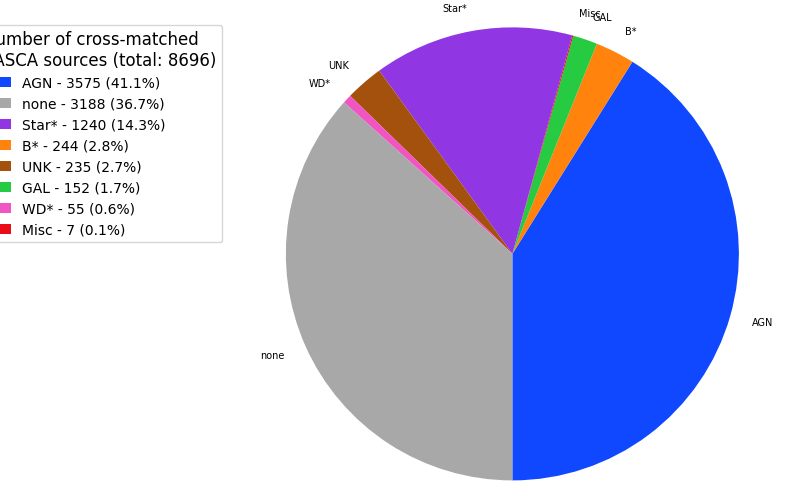

In [6]:
# Pie chart showing fractions of grouped classification

# Grouped classifications
sel_mt = rc.tt_sources["sel"]
plabel, pvals = np.unique(rc.tt_sources[sel_mt]["ogrp_simbad"],return_counts=True)
percent = [i/pvals.sum()*100 for i in pvals]

# Figure (notebook-optimized)
fig, ax = nb_fig(num="class pie", gr_size=8, layout="constrained")

# Seaborn colors
alpha = 0.95
c_bright_rgb = color_palette(name="bright", n=len(plabel), show_in_notebook=False)
c_bright_rgba = [(*c[:3], alpha) for c in c_bright_rgb]

# Chart
patches, text = ax.pie(pvals,
					   labels=plabel,
					   colors=c_bright_rgba,
					   startangle=270,
					   radius=1.2,
					   textprops={'fontsize': 7}
					  )

# External legend, sorted by percentage
xlabels = [f'{i} - {j:d} ({k:1.1f}%)' for i,j,k in zip(plabel, pvals, percent)]
sort_legend = True
if sort_legend:
	patches, labels, _ =  zip(
		*sorted(
			zip(patches, xlabels, pvals),
			key=lambda x: x[2],
			reverse=True
		)
	)
_=ax.legend(
	patches,
	labels,
	loc='best',
	bbox_to_anchor=(-0.1, 1.),
	fontsize=10,
	title=f"Number of cross-matched\nVASCA sources (total: {pvals.sum()})",
	title_fontsize=12,
	alignment='left',
)

### Scatter plots of source variables by group

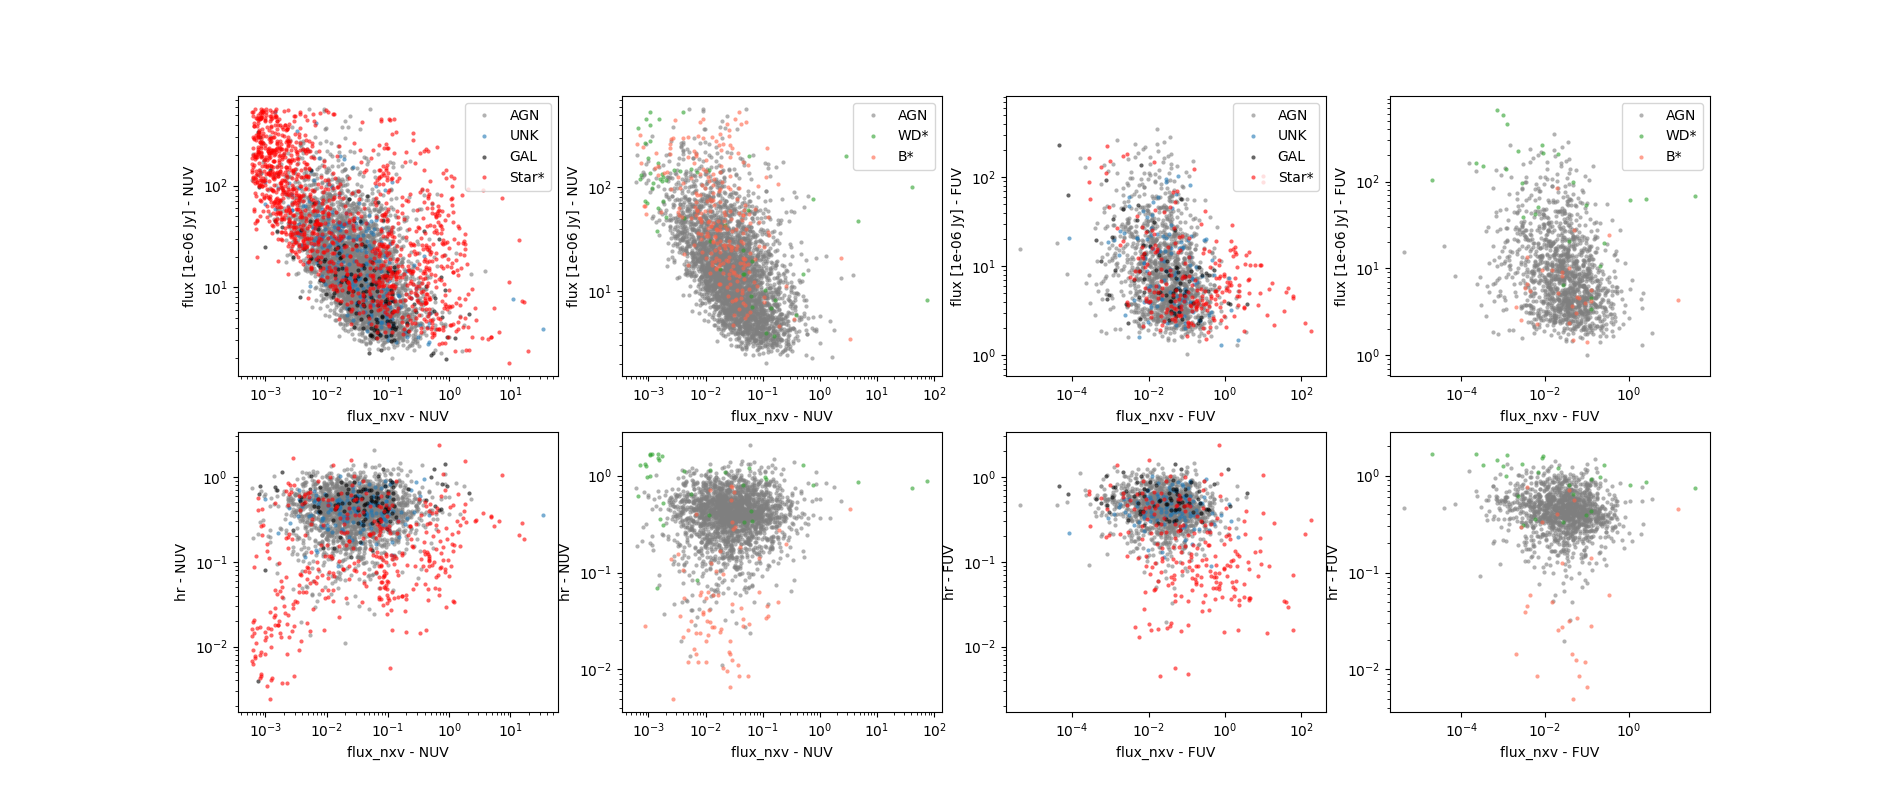

In [7]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star*'],["AGN",'WD*', 'B*']]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)

        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Compare object classification from SIMBAD to the one from GAIA-DR3

/home/buehler/miniforge3/envs/vas/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy


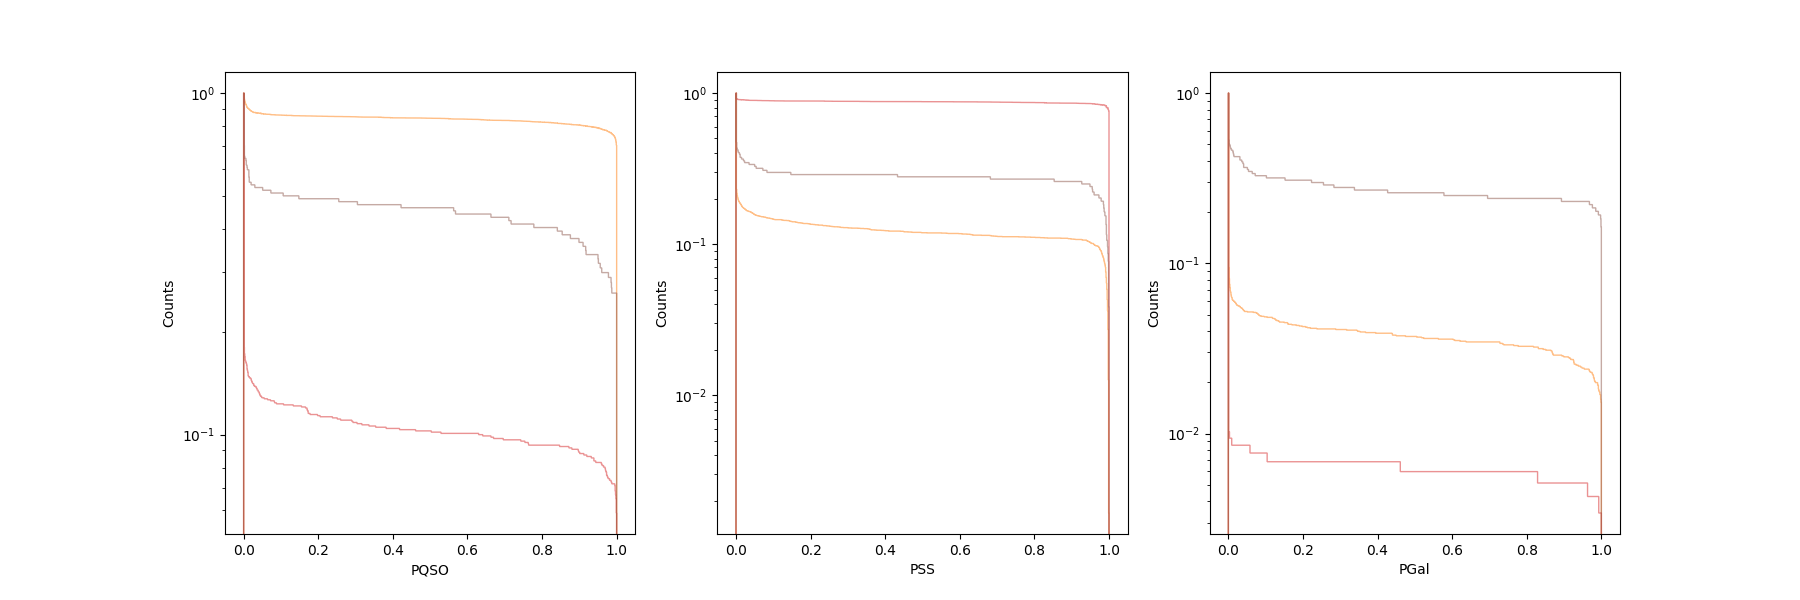

In [8]:
#Reset source selection
rc.tt_sources["sel"]=True

#Define selections for different SIMBAD object groups
sel_AGN = rc.tt_sources["ogrp_simbad"]=="AGN"
sel_star = np.array((rc.tt_sources["ogrp_simbad"]=="Star*")+(rc.tt_sources["ogrp_simbad"]=="S*"), dtype=bool)
sel_gal = rc.tt_sources["ogrp_simbad"]=="GAL"
sels_ogrp = [sel_AGN,sel_star,sel_gal]

#GAIA variables to plot
gaia_vars = ["PQSO","PSS","PGal"]

#Define figure parameters and loop to do plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6),num="Cummulative probabilities of object groups")
hist_bins = np.linspace(0.0,1.0,1001)
hist_dens = True
axs = np.array(axs).flatten()
panel = 0
cumulative = -1
for var in gaia_vars:
    for sel in sels_ogrp:
        _ = vvis.plot_table_hist(rc.tt_sources[sel], var, ax=axs[panel], density= hist_dens, bins=hist_bins,cumulative= cumulative )
    panel+=1
    
#Print out figure labels
print("SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy")

### Hertzsprung russel diagram

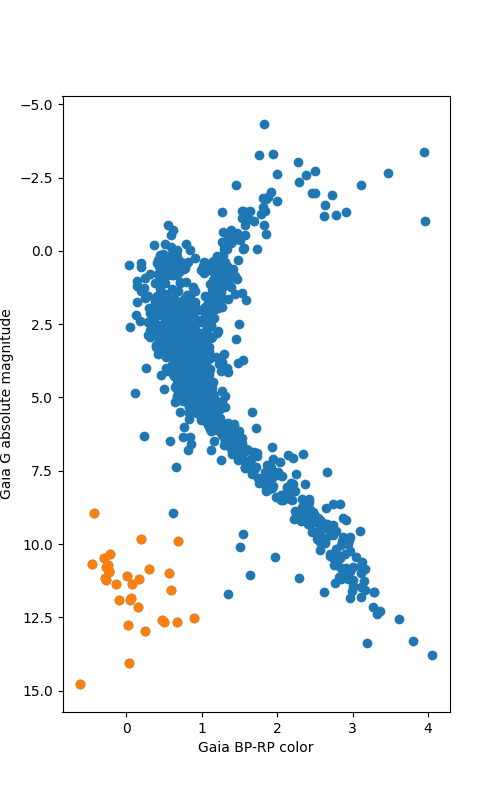

In [9]:
tt_HR = rc.tt_sources[rc.tt_sources["Gmag_abs"]>-10]
fig, axs = plt.subplots(1, 1, figsize=(5, 8),num="HR", clear=True)
axs = np.array(axs).flatten()
axs[0].invert_yaxis()
axs[0].plot(tt_HR["BP-RP"],tt_HR["Gmag_abs"],"o")
#axs[0].invert_yaxis()
axs[0].plot(tt_HR["BP-RP"][tt_HR["ogrp_gaiadr3"]=="WD*"],tt_HR["Gmag_abs"][tt_HR["ogrp_gaiadr3"]=="WD*"],"o")
#axs[0].invert_yaxis()
axs[0].set_xlabel("Gaia BP-RP color")
axs[0].set_ylabel("Gaia G absolute magnitude")
plt.show()

### Print info for selected sources

In [10]:
# Make selection
sel_otype = rc.tt_sources["otype"] ==  "RR*"# "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (rc.tt_sources["otype"] ==  "WD?")  + (rc.tt_sources["otype"] =="WD*") + (rc.tt_sources["ogrp_gaiadr3"] =="WD*")
sel_flux_nxv = rc.tt_sources["flux_nxv"][:,0]>2
sel_flux_hr = rc.tt_sources["hr"]>2
sel_src_id = rc.tt_sources["rg_src_id"]==15179
sel_period = (rc.tt_sources["ls_peak_pval"]>-0.5) * (rc.tt_sources["ls_peak_pval"]<0.000000573303) * (rc.tt_sources["ls_model_rchiq"]<1.1)# # 3 sigma 0.002699796063, 4 sigma 0.000063342484, 5 sigma 0.000000573303
sel_srcs =  sel_otypes #sel_period #sel_otypes  #sel_src_id  #sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(rc.tt_sources[sel_srcs])

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in rc.tt_sources[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")
print("Total Nr. of sources:",sel_srcs.sum())

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,simbad_match_id,gaiadr3_match_id,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3,ls_peak_pval,ls_model_rchiq
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,arcsec,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32,float32,int64,int32,int32,float32,float32,int32,int32,bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32
-1,149 .. 75,334.37177337994245,0.14260354697811373,0.03619791,-0.040783845,0.25818115,0.5168897,0.8634286,13745,0.39278755,1 .. 2,True,138.31387 .. 137.74933,0.19226342 .. 0.48882502,0.0010596871 .. 0.001172697,30.370586 .. 67.69505,0.0 .. 2.9569552e-12,4.168547 .. 2.57761,-100.0,-10000.0,-1,4993,6,0.9947147,0.004240999,77,59,WD*,WD*,0.44933927,0.0,0.000106,5e-05,0.2508642,11.156714,-0.284372,WD*,0.008928546,3.5938787
-1,67 .. 39,35.2418133124936,-5.3268123630922135,0.06502271,-0.3229914,0.15286975,1.0,0.28614402,1145,0.12559491,1 .. 2,True,15.821138 .. 6.6184993,0.107664794 .. 0.13884212,0.018202145 .. 0.016439592,5.4822593 .. 1.691587,0.0 .. 0.00016123278,7.048383 .. 2.0399196,-100.0,-10000.0,-1,13580,6,0.40061885,0.009090735,214,185,QSO,AGN,0.52806926,0.993016,1e-05,0.006973,0.49571055,12.667274,0.670643,WD*,0.000118549106,4.4332905
-1,60 .. 8,334.0564353836822,1.0823032174516622,0.071758375,-0.19766761,0.20903327,0.999543,0.47470582,182502,0.18124859,1 .. 2,True,38.38036 .. 2.679372,0.17047885 .. 0.243022,0.0013976777 .. -0.061310105,4.7909384 .. 0.08948734,1.1513696e-09 .. 0.9945474,2.5167742 .. 0.14530437,-100.0,-10000.0,-1,14504,5,0.069159366,0.007200482,234,209,WD*,WD*,0.10859099,0.005006,0.0,5.4e-05,0.7428757,12.962516,0.243813,WD*,0.2466465,2.034905
-1,107 .. 67,334.89381197775845,0.8818548523370469,0.041174985,-0.08103674,0.2217848,0.8422387,0.74226123,-1,-1.0,1 .. 2,True,73.96888 .. 97.4021,0.17897125 .. 0.4263391,0.00086351973 .. 0.002901708,11.258695 .. 56.12075,5.322324e-07 .. 3.1927897e-08,1.8188289 .. 2.2414591,-100.0,-10000.0,-1,30475,4,1.3034943,0.007536973,380,350,WD?,WD*,0.47096086,1e-06,0.001718,5e-05,0.52298284,11.100542,0.008362,WD*,0.003767448,1.4492389
-1,43 .. 3,160.98628310403117,58.125564453570256,0.074825816,-0.0422247,0.21750309,0.09029268,0.8487536,66343,0.08939208,1 .. 2,True,200.6113 .. 207.43813,0.38346985 .. 2.5625901,0.05843502 .. 0.021001792,2359.2112 .. 923.8086,0.0 .. 7.736314e-22,293.0358 .. 48.610947,-100.0,-10000.0,-1,50388,4,1.2079993,0.017565036,539,549,CV*,WD*,0.34217268,0.954205,0.0,0.000938,0.78164876,10.973606,0.562086,WD*,0.16768725,209.25395
-1,64 .. 25,150.54540974779889,2.9726705626470653,0.056498617,-0.09341755,0.19603774,0.9513494,0.67751217,-1,-1.0,1 .. 2,True,121.049805 .. 152.51727,0.28894272 .. 0.717161,0.00071297085 .. 0.0003327147,20.466846 .. 45.010082,2.4744158e-09 .. 3.07255e-06,2.414412 .. 2.8759015,-100.0,-10000.0,-1,52994,4,1.3008265,0.0094726635,580,589,WD*,WD*,0.51640373,0.0,0.0,5e-05,0.5069858,10.724965,-0.24329,WD*,0.0026768018,1.6505754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,14 .. -1,289.38193004645626,-24.317275553240115,0.13391653,0.14687224,0.39796337,0.0037673684,1.5858692,-1,-1.0,1 .. 0,True,192.32353 .. -1.0,0.69674796 .. -1.0,0.0009987517 .. -100.0,43.771828 .. -1.0,2.9986267e-12 .. -1.0,6.3845806 .. -1.0,-100.0,-10000.0,-1,1069077,1,-1.0,-1.0,4096,5775,WD?,WD*,0.10722022,0.0,0.0,0.999998,0.07536331,-100.0,-0.220705,Star*,-1.0,-1.0


srcs_ids = [4993 ,13580 ,14504 ,30475 ,50388 ,52994 ,79477 ,120265 ,138783 ,139480 ,162697 ,204419 ,221349 ,228958 ,236839 ,253214 ,253670 ,256433 ,261213 ,331466 ,340464 ,381336 ,390864 ,489430 ,498065 ,525310 ,532554 ,533185 ,540235 ,583838 ,639720 ,645215 ,645730 ,659787 ,666224 ,673175 ,680119 ,691408 ,714140 ,764827 ,1037284 ,1069077 ,1070938 ,1805505 ,1839206 ,2527679 ,3074917 ,]
Total Nr. of sources: 47


In [11]:
tt_nodes = Table.read("./resources/SIMBAD_otypes/otypes_nodes.csv")
tt_nodes.rename_column("Id", "otype")
#display(tt_nodes)
add_ogrp(tt_nodes)
tt_nodes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"].pprint_all()

otype Candidate                   Description                     ogrp     Label                        Category                                          Subcategory                         
                                                                                                                                                                                              
----- --------- ------------------------------------------------ ----- -------------- ------------------------------------------- ------------------------------------------------------------
    ?        --                         Object of Unknown Nature   UNK        Unknown 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --
  ..1        --                     {pr*} Pre-Main Sequence Star  none             --                        1. TAXONOMY OF STARS              Young Stellar Objects (Pre-Main Sequence Stars)
 ..10        --                              

In [12]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)